# Parte 2: Face Detection
### Santiago Juani & Florencia Migues

## Imports

In [1]:
import cv2 
import numpy as np
from glob import glob
from enum import Enum
import os
import sklearn
from skimage.feature import hog
from sklearn import svm
import sklearn.neighbors
import matplotlib.pyplot as plt
from evaluation import evaluate_detector, precision_and_recall, interpolated_average_precision
import sys
from image_utils import non_max_suppression
from tqdm import tqdm
import pandas as pd
import pickle as pickle

## Feature Estractors
#### Implementacion: Hog

In [2]:
class FeatureExtractors(Enum):
		MiniImage = 1
		HOG = 2
		LBP = 3

def extract_features(method, image):
	'''Switch between Feature extraction Methods'''

	image_representation = []

	if method == FeatureExtractors.MiniImage:
		image_representation = extract_mini_image_features(image)
	elif method == FeatureExtractors.HOG:
		image_representation = extract_hog_features(image)
	elif method == FeatureExtractors.LBP:
		image_representation = extract_lbp_features(image)	
	
	return image_representation

def extract_mini_image_features(image,resize_size=(64,64)):
    shape = image.shape
    if len(shape) > 2:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    resized_image = cv2.resize(image,resize_size)
    image_representation = resized_image.reshape(resize_size[0]*resize_size[1])
    return image_representation
  
def extract_lbp_features(img):
    return []

def extract_hog_features(img):
    #img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    fd = hog(img, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=False)
    return fd

## Data Loader & ShowImg

In [71]:
def load_training_data(training_positive_dir,trainign_negative_dir,feature_extractor=FeatureExtractors.HOG,target_size=[128,128]):
    ''' Function for loading loading training data from positive and negative examples
    '''
    positive_img_files = sorted(glob(training_positive_dir + '/*'))
    negative_img_files = sorted(glob(trainign_negative_dir + '/*'))
    positive_img_files = positive_img_files[:5000]
    negative_img_files = negative_img_files[:5000]
    training_data = []
    training_labels = []
    
    print('##Loading {} positive face images'.format(len(positive_img_files)))
    for img in tqdm(positive_img_files, total=len(positive_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(1)
    
    print('##Loading {} negative face images'.format(len(negative_img_files)))
    for img in tqdm(negative_img_files,total=len(negative_img_files)):
        image = cv2.imread(img)[...,::-1]
        image = cv2.resize(image, target_size, cv2.INTER_AREA)
        image_representation = extract_features(feature_extractor,image)
        training_data.append(image_representation)
        training_labels.append(0)   
    
    training_data = np.asarray(training_data)
    training_labels = np.asarray(training_labels)
    return training_data, training_labels

def load_validation_data(validation_data_dir):

    validation_image_files = sorted(glob(validation_data_dir + '/*.jpg'))
    val_images = []
    validation_annotations= pd.read_pickle(os.path.join(validation_data_dir,'validation_bbox.pickle'))
    print(validation_annotations.shape)
    validation_bboxes = []
    for img_file in tqdm(validation_image_files,total=len(validation_image_files)):
        image = cv2.imread(img_file,cv2.IMREAD_COLOR)
        val_images.append(image)
        image_name = os.path.basename(img_file)
        bbox_info = validation_annotations.loc[validation_annotations["image_id"]==image_name]
        bbox = np.array([bbox_info['x_left'].values[0],bbox_info['y_top'].values[0],bbox_info['x_left'].values[0]+bbox_info['width'].values[0],bbox_info['y_top'].values[0]+bbox_info['height'].values[0]])
        validation_bboxes.append(bbox)
        
    return val_images, validation_bboxes

def show_image_with_bbox(image,bboxes,gt_bbox,draw_GT=True):
    if draw_GT: 
        cv2.rectangle(image, (gt_bbox[0],gt_bbox[1]), (gt_bbox[2],gt_bbox[3]), (0, 0, 255), 2)

    for bbox in bboxes:
        if len(bbox) == 4:   
            top_left = (int(bbox[0]),int(bbox[1]))
            bottom_right = (int(bbox[0])+ int(bbox[2]),int(bbox[1])+int(bbox[3]))
            cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(image[...,::-1])
    plt.axis('off')
    plt.show()

## Sliding Window
Implementacion propia

In [57]:
def sliding_window(img, window_size, scale, step_size):
    
    # Resize #
    
    width = int(img.shape[1]*scale)
    height = int(img.shape[0]*scale)
    dim = (width, height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    # ------ #
    
    [i_rows, i_cols] = img.shape;
    w_rows = window_size[0];
    w_cols = window_size[1];
    
    cc = (i_cols - w_cols)//step_size
    cr = (i_rows - w_rows)//step_size
    ct = cc*cr
            
    patches = np.zeros((w_rows, w_cols,ct))
    bbox_locations = np.zeros((ct, 4))
    
    i=0
    current_y = 0
    for r in range(cr):
        current_x = 0
        for c in range(cc):
            patches[:,:,i] = img[current_y:current_y+w_rows, current_x:current_x+w_cols]
            bbox_locations[i,:] = [current_y, current_x,w_rows, w_cols]
            i+=1
            current_x += step_size
        current_y += step_size
        
    return patches, bbox_locations   

In [72]:
def total_windows(img, window_size, step_size):
    [i_rows, i_cols] = img.shape;
    w_rows = window_size[0];
    w_cols = window_size[1];
    
    cc = (i_cols - w_cols)//step_size
    cr = (i_rows - w_rows)//step_size
    return cc*cr

def sliding_window(img, window_size, scale, step_size):
    
    scales = [scale, 3*(scale/4), scale/2, scale/4]
    images = []
    
    ct = 0
    
    for s in scales:
        width = int(img.shape[1]*s)
        heigh = int(img.shape[0]*s)
        
        image = cv2.resize(img, (width, heigh),
                           interpolation = cv2.INTER_AREA)
        
        if (image.shape[0] < window_size[0] or image.shape[1] < window_size[1]):
            break
        
        images.append(image)
        ct += total_windows(image, window_size, step_size)
    
    patches = np.zeros((window_size[0], window_size[1], ct))
    bbox_locations = np.zeros((ct, 4))
    
    i=0
    for image in images:
        for y in range(0, image.shape[0], step_size):
            for x in range(0, image.shape[1], step_size):
                try:
                    patches[:,:,i] = image[y:y+window_size[0], x:x+window_size[1]]
                    bbox_locations[i,:] = [y, x, window_size[0], window_size[1]]
                    i+= 1
                except:
                    pass
                    
    return patches, bbox_locations

# Entrenamiento del Modelo

## Carga de datos de entrenamiento

#### Ubicacion de los datos

In [73]:
data_dir='./'
face_detection_dir = os.path.join(data_dir, 'face_detection')
training_faces_dir = os.path.join(face_detection_dir,'cropped_faces')
negative_examples_training_dir = os.path.join(face_detection_dir,'negative_data')
validation_faces_dir = os.path.join(face_detection_dir,'validation')
validation_raw_faces_dir = os.path.join(face_detection_dir,'val_raw_images')

#### Load Training Data

In [74]:
training_data, training_labels = load_training_data(training_faces_dir,
                                                   negative_examples_training_dir,
                                                   FeatureExtractors.HOG)

  1%|          | 35/5000 [00:00<00:29, 169.93it/s]

##Loading 5000 positive face images


  1%|          | 36/5000 [00:00<00:28, 175.60it/s]

##Loading 5000 negative face images


100%|██████████| 5000/5000 [00:28<00:00, 174.02it/s]


#### Load Validation Data

In [75]:
validation_data = load_validation_data(validation_faces_dir)

 23%|██▎       | 41/175 [00:00<00:00, 409.63it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 443.31it/s]


#### Entrenar el clasificador SVM de sklearn

In [76]:
svm_classifier = svm.SVC(kernel='linear',
                         probability=True)

In [77]:
svm_classifier.fit(training_data, training_labels)

SVC(kernel='linear', probability=True)

#### Save trained model

In [78]:
pickle.dump(svm_classifier, open('./face_detector', 'wb'))

#### Load trained model

In [79]:
classifier = pickle.load(open('./face_detector','rb'))

## Sliding Window & Results

 27%|██▋       | 47/175 [00:00<00:00, 464.92it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 361.24it/s]


(128, 128, 55)


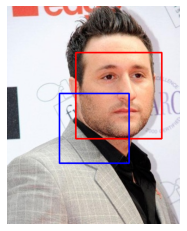

(128, 128, 42)


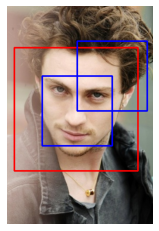

(128, 128, 78)


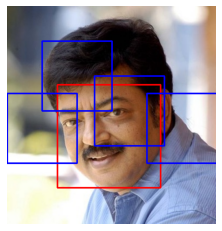

(128, 128, 10)


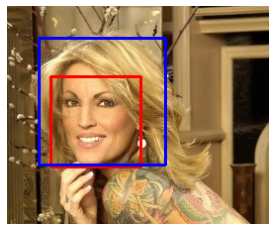

(128, 128, 93)


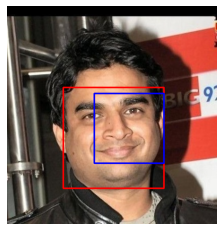

(128, 128, 42)


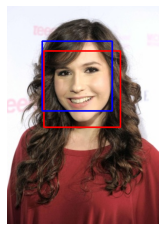

(128, 128, 55)


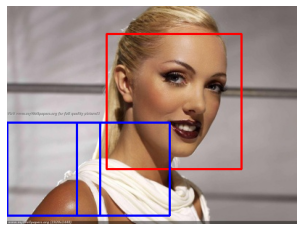

(128, 128, 42)


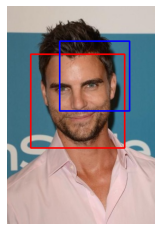

(128, 128, 42)


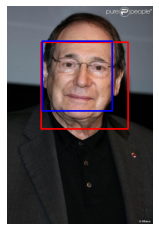

(128, 128, 50)


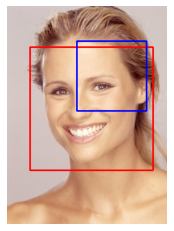

(128, 128, 65)


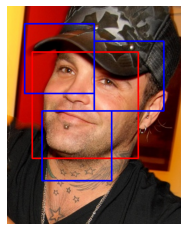

(128, 128, 42)


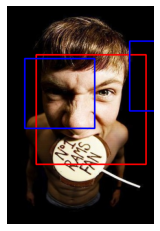

(128, 128, 78)


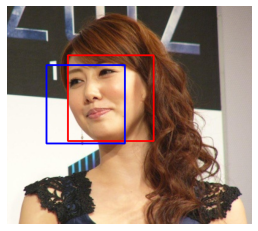

(128, 128, 50)


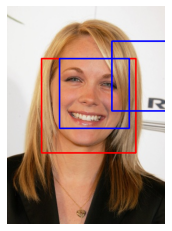

(128, 128, 78)


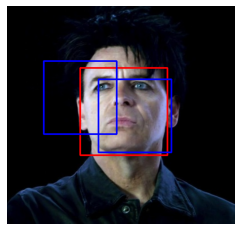

(128, 128, 78)


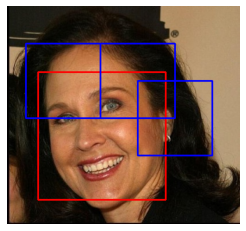

(128, 128, 42)


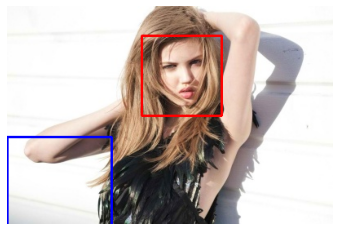

(128, 128, 50)


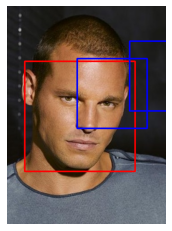

(128, 128, 42)


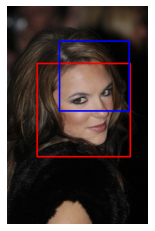

(128, 128, 42)


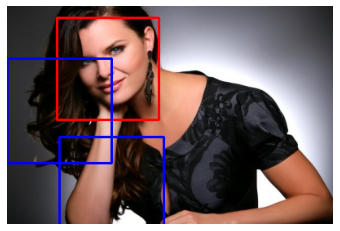

In [80]:
window_size = (128, 128)
scale = 1
predictions = []
threshold_p = 0.5
overlap_threshold = 0.5
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
sample_images = 20
stride = 32
for img, gt_bbox in zip(validation_data[:sample_images],validation_bboxes[:sample_images]):
    #print(img.shape)
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    print(patches.shape)
    
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.HOG, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get prediction label for each sliding window patch
    if patches_feature_representation.shape[0] > 0:
        scores = classifier.predict_proba(patches_feature_representation)
        ## Positive Face Probabilities
        face_probabilities = scores[:,1]
        face_bboxes = bbox_locations[face_probabilities>threshold_p]
        face_bboxes_probabilites = face_probabilities[face_probabilities>threshold_p]
        # Do non max suppression and select strongest probability box
        [selected_bbox, selected_score] = non_max_suppression(face_bboxes,face_bboxes_probabilites,0.3)
    else:
        selected_bbox = []
    show_image_with_bbox(img, selected_bbox,gt_bbox)

## Evaluate Detector

In [81]:
total_true_positives = []
total_real_positives = []
total_positive_predictions = []
window_size = [128, 128]
validation_data, validation_bboxes = load_validation_data(validation_faces_dir)
k = 0
stride = 8
for img, gt_bbox in zip(validation_data,validation_bboxes):
    gray_image = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    patches, bbox_locations = sliding_window(gray_image,window_size,scale,stride)
    ## You need to extract features for every patch (same features you used for training the classifier)
    patches_feature_representation = []
    for i in range(patches.shape[2]):
        patch_representation = extract_features(FeatureExtractors.HOG, patches[:,:,i])
        patches_feature_representation.append(patch_representation)
    patches_feature_representation = np.asarray(patches_feature_representation)
    ## Get score for each sliding window patch
    scores = classifier.predict_proba(patches_feature_representation)
    ## Positive Face Probabilities
    face_probabilities = scores[:,1]
    ## liblinbear prediction
    #[labels, acc, prob] = predict([],patches_feature_representation, clasifier)
    #face_probabilities = np.asarray(prob)
    #face_probabilities = face_probabilities.T[0]

    [ detected_true_positives, image_real_positives, detected_faces ] = evaluate_detector( bbox_locations, face_probabilities);
    total_true_positives.append(detected_true_positives)
    total_real_positives.append(image_real_positives)
    total_positive_predictions.append(detected_faces)
        
total_true_positives = np.asarray(total_true_positives)
total_real_positives = np.asarray(total_real_positives)
total_positive_predictions = np.asarray(total_positive_predictions)

 26%|██▋       | 46/175 [00:00<00:00, 455.26it/s]

(175, 5)


100%|██████████| 175/175 [00:00<00:00, 469.27it/s]


In [82]:
precision, recall = precision_and_recall(total_true_positives, total_real_positives,total_positive_predictions)

(0.0, 1.1)

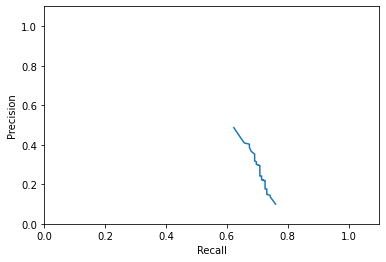

In [83]:
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)

In [85]:
ap = interpolated_average_precision(recall,precision)
print('Detection Average Precision is {}'.format(ap))

Detection Average Precision is [0.30308673]


### Profe:
0.00190476

### Implementacion:
0.11652348

0.30308673